In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

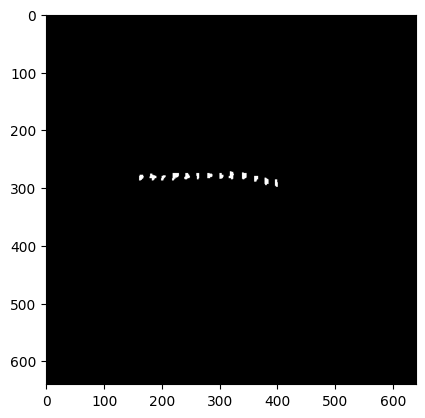

In [2]:
real_mask = cv2.imread('real_mask.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(real_mask, cmap='gray')
plt.show()

In [3]:
# dataset path
PATH = 'test.v1i.yolov8'

In [4]:
# lists labels files in test split (TODO: add train,validation...)
file_names = [f[:-4] for f in os.listdir(PATH+'/test/labels') if f.endswith('.txt')]
file_names

['DepthViewer_Left_35355388_1242_20-03-2023-11-17-45_png.rf.fa9fc9c1205bfea6f9fc98b218bdfebe']

DepthViewer_Left_35355388_1242_20-03-2023-11-17-45_png.rf.fa9fc9c1205bfea6f9fc98b218bdfebe


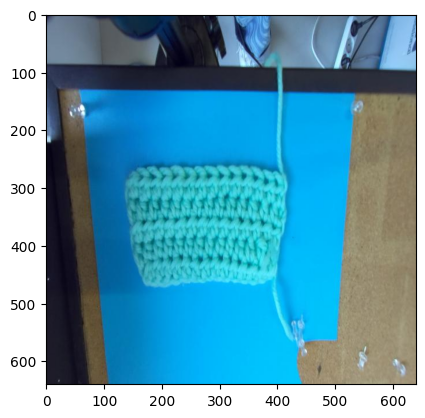

MASK TO COMPARE


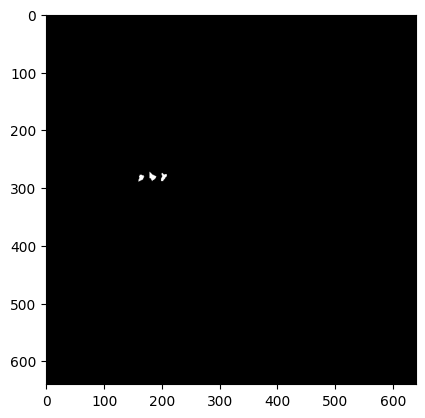

In [5]:
#Focus in first image in list
f = file_names[0]

#REUSE: generate mask by category
categories = 2
print(f)
# load image
img = cv2.imread(PATH+'/test/images/'+f+'.jpg')
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)
plt.show()
img_h, img_w, _ = img.shape

#Load label file
txt_file = open(PATH+'/test/labels/'+f+'.txt')
lines = txt_file.readlines()

# Generate mask by category
masks = np.zeros((categories, img_h, img_w))
for line in lines:
    line_info = line[:-1].split(' ') #quit \n symbol and split y space
    category = int(line_info[0])
    points = np.array(line_info[1:], np.float64)
    points = points.reshape((int(points.shape[0]/2)),2)
    points[:,0] = points[:,0]*img_w
    points[:,1] = points[:,1]*img_h

    #Draw mask        
    cv2.drawContours(masks[category,:,:], [points.astype(np.int32)], -1, 1, -1)

print('MASK TO COMPARE')
mask = masks[0,:,:]
plt.imshow(mask, cmap='gray')
plt.show()

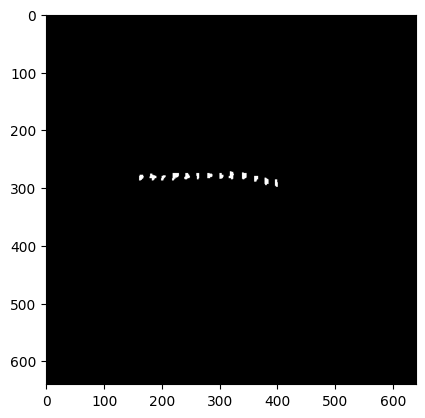

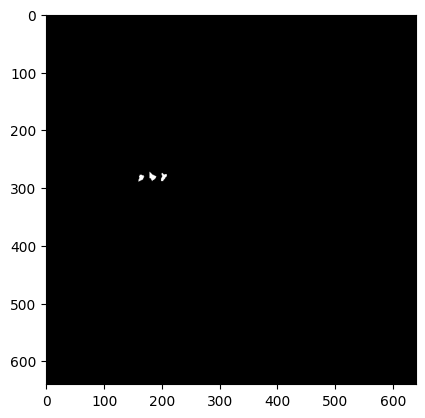

In [6]:
#we want to compare real_mask y other mask

plt.imshow(real_mask, cmap='gray')
plt.show()

plt.imshow(mask, cmap='gray')
plt.show()

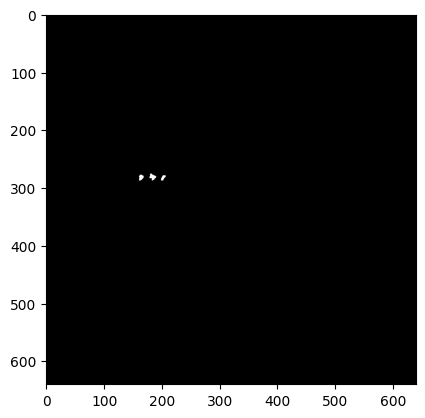

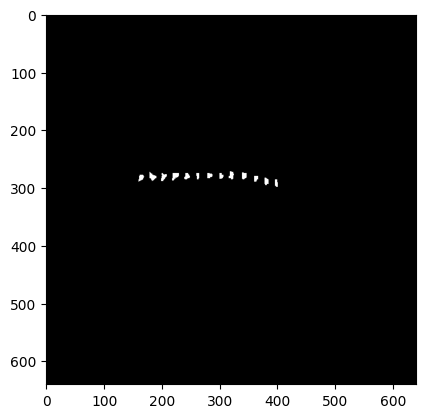

IoU is 0.19140225179119755


In [7]:
# IoU calculation
intersection = np.logical_and(real_mask, mask)
union = np.logical_or(real_mask, mask)
iou_score = np.sum(intersection) / np.sum(union)

plt.imshow(intersection,cmap='gray')
plt.show()

plt.imshow(union, cmap='gray')
plt.show()

print('IoU is %s' % iou_score)

In [8]:
#code from https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation

def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [9]:
real_contours, _ = cv2.findContours(real_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

real_bbox = []
for cnt in real_contours:
    bb = {}
    bb['x1'], bb['y1'], w, h = cv2.boundingRect(cnt)
    bb['x2'] = bb['x1']+w
    bb['y2'] = bb['y1']+h
    real_bbox.append(bb)

obt_contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

obt_bbox = []
for cnt in obt_contours:
    bb = {}
    bb['x1'], bb['y1'], w, h = cv2.boundingRect(cnt)
    bb['x2'] = bb['x1']+w
    bb['y2'] = bb['y1']+h
    obt_bbox.append(bb)

In [10]:
#Code adapted from https://github.com/svpino/tf_object_detection_cm/blob/master/confusion_matrix.py
confusion_matrix = np.zeros((2,2))

IOU_THRESHOLD = 0.6
matches = []
for i in range(len(real_bbox)):
    for j in range(len(obt_bbox)):
        iou = get_iou(real_bbox[i], obt_bbox[j])

        if iou > IOU_THRESHOLD:
            matches.append([i, j, iou])

matches = np.array(matches)      

if matches.shape[0] > 0:
    # Sort list of matches by descending IOU so we can remove duplicate detections
    # while keeping the highest IOU entry.
    matches = matches[matches[:, 2].argsort()[::-1][:len(matches)]]

    # Remove duplicate detections from the list.
    matches = matches[np.unique(matches[:,1], return_index=True)[1]]

    # Sort the list again by descending IOU. Removing duplicates doesn't preserve
    # our previous sort.
    matches = matches[matches[:, 2].argsort()[::-1][:len(matches)]]

    # Remove duplicate ground truths from the list.
    matches = matches[np.unique(matches[:,0], return_index=True)[1]]

print(matches)
    
for i in range(len(real_bbox)):
    if matches.shape[0] > 0 and matches[matches[:,0] == i].shape[0] == 1:
        confusion_matrix[0][0] += 1 
    else:
        confusion_matrix[1][0] += 1
                    
for i in range(len(obt_bbox)):
    if matches.shape[0] > 0 and matches[matches[:,1] == i].shape[0] == 0:
        confusion_matrix[0][1] += 1
        
print(confusion_matrix)
#TODO: obtain metrics from confusion matrix

[[4.         0.         0.66666667]
 [5.         2.         0.75      ]]
[[ 2.  1.]
 [11.  0.]]
